# Plot TKE Data

LJK

Date created: 04/08/25

Last edited: 08/12/25

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt

from config import *

In [2]:
fontsize = 18

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

In [3]:
metadata_df = pd.read_csv(data_dir + 'AVISO_metadata_15km_near_eddy.csv',index_col=0)
metadata_df[12:].head()

,sample_id,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc
14,16,20211120,10:54,29.0000,236.5574,0,0,0,0
15,17,20211120,12:44,28.7390,236.1088,0,0,0,0
16,18,20211120,14:43,28.5030,235.7140,0,0,0,0
17,19,20211121,02:03,28.2847,235.3517,0,0,0,0
18,20,20211121,04:04,28.0397,234.9534,0,0,0,0


In [4]:
ds = xr.open_dataset(data_dir + 'TKEgen-daily-2020-2021_with_MLD.nc')
ds

<xarray.Dataset>
Dimensions:      (times: 731, lat: 121, lon: 161)
Dimensions without coordinates: times, lat, lon
Data variables:
    TKEgen       (times, lat, lon) float32 ...
    TKEgen_wind  (times, lat, lon) float32 ...
    TKEgen_heat  (times, lat, lon) float32 ...
    MLD          (times, lat, lon) float32 ...
    longitude    (lon) float32 ...
    latitude     (lat) float32 ...
    date         (times) datetime64[ns] ...
Attributes:
    title:    TKE generation rate using ORA5 reanalysis data - 1990-2022

Crop to:
- Lon 215-240
- Lat 15-35

In [5]:
lon = ds.longitude + 360
lat = ds.latitude
times = ds.date

lon_min,lon_max = 215,240
lat_min,lat_max = 15,35

In [6]:
np.shape(ds.TKEgen) # times,lat,lon

(731, 121, 161)

In [7]:
lat_inds = np.where((lat>=lat_min) & (lat <=lat_max))[0]
lon_inds = np.where((lon>=lon_min) & (lon<=lon_max))[0]

In [8]:
TKE_cropped = ds.TKEgen[:,lat_inds,lon_inds]
TKE_cropped_time_mean = np.nanmean(np.nanmean(TKE_cropped,axis=1),axis=1)
np.shape(TKE_cropped_time_mean)

(731,)

In [9]:
MLD_cropped = ds.MLD[:,lat_inds,lon_inds]
MLD_cropped_time_mean = np.nanmean(np.nanmean(MLD_cropped,axis=1),axis=1)
np.shape(MLD_cropped_time_mean)

(731,)

In [10]:
np.where(times >= np.datetime64('2021-11-27'))[0]

array([696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708,
       709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721,
       722, 723, 724, 725, 726, 727, 728, 729, 730])

Calculate rolling mean of TKE

In [11]:
df = pd.DataFrame({'TKE':TKE_cropped_time_mean,'MLD':MLD_cropped_time_mean})
df.head()

,TKE,MLD
0,2.965536,78.621658
1,2.074744,78.621658
2,0.934105,78.621658
3,0.973765,78.621658
4,2.162281,78.621658


In [12]:
df['TKE_rolling_mean'] = df['TKE'].rolling(window=60,center=True,min_periods=30).mean()
df['MLD_rolling_mean'] = df['MLD'].rolling(window=60,center=True,min_periods=30).mean()

Text(-135, 94, 'b)')

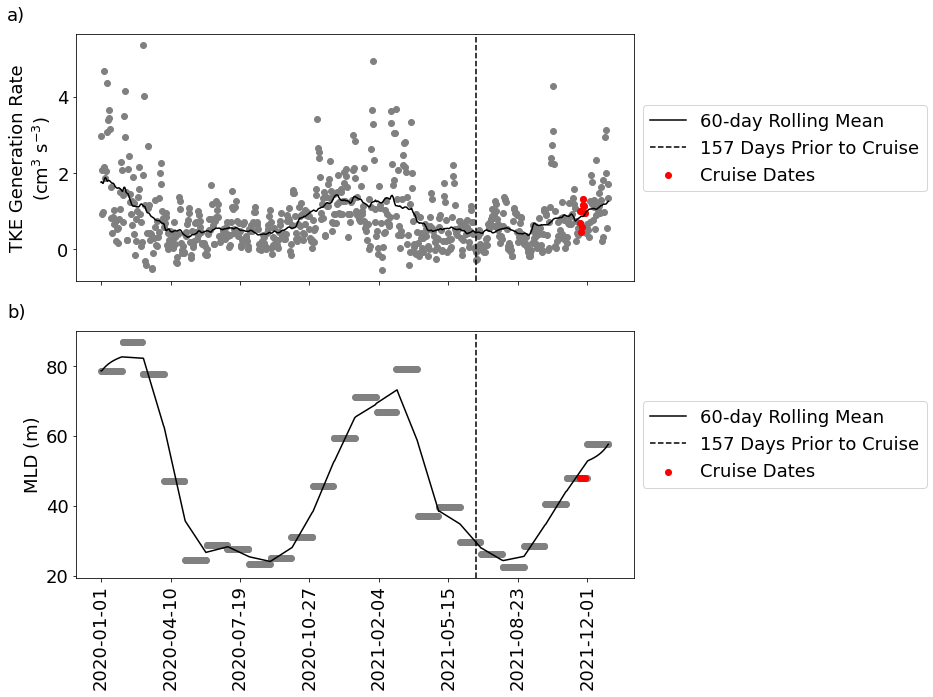

In [13]:
fig,ax = plt.subplots(2,1,figsize=(10,10))  

ax[0].scatter(np.arange(0,len(times)),TKE_cropped_time_mean,c='gray')
ax[0].plot(df['TKE_rolling_mean'],c='k',label='60-day Rolling Mean')
ax[0].set_ylabel('TKE Generation Rate\n(cm$^3$ s$^{-3}$)')

ax[1].scatter(np.arange(0,len(times)),MLD_cropped_time_mean,c='gray')
ax[1].plot(df['MLD_rolling_mean'],c='k',label='60-day Rolling Mean')
ax[1].set_ylabel('MLD (m)')

cruise_inds = np.where((times >= np.datetime64('2021-11-20')) & (times <= np.datetime64('2021-11-27')))[0]
ax[0].scatter(np.arange(0,len(times))[cruise_inds],TKE_cropped_time_mean[cruise_inds],c='r',label='Cruise Dates')
ax[1].scatter(np.arange(0,len(times))[cruise_inds],MLD_cropped_time_mean[cruise_inds],c='r',label='Cruise Dates')

for a in [0,1]:
    ax[a].axvline(cruise_inds[-1]-157,label='157 Days Prior to Cruise',c='k',linestyle='--')
    ax[a].legend(bbox_to_anchor=(1,0.75))
    ax[a].set_xticks(np.arange(0,800,100))
    
ax[0].set_xticklabels([])
ax[1].set_xticklabels([str(t)[0:10] for t in times[::100].values],rotation=90)

ax[0].text(-135,6,'a)')
ax[1].text(-135,94,'b)')

#plt.savefig(euk_paper_dir + 'figs/supp/TKEgeneration_MLD.pdf',dpi=350, bbox_inches='tight', format='pdf')